# 模式识别课后作业1

- 姓名：陈璟
- 学号：2023217542
- 班级：智能科技23-2班

## 作业目标

1. 下载并探索红酒质量数据集，完成特征工程分析；
2. 将质量评分转换为二分类标签，并观察类别分布；
3. 实现基于梯度下降的逻辑回归模型并进行交叉验证；
4. 调用 scikit-learn 中的逻辑回归模型进行对比实验；
5. 对实验过程和结果进行总结归纳。

## 1. 环境与数据准备

下面将会自动检查数据集是否存在于 `data/winequality-red.csv`，
若不存在则尝试从 UCI 仓库下载。若在本地/教学平台运行时无法联网，
请手动将数据集放置于指定路径。

In [1]:
from pathlib import Path
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

plt.rcParams['figure.figsize'] = (8, 5)
sns.set_theme(style='whitegrid', context='notebook')

In [2]:
DATA_DIR = Path('data')
DATA_DIR.mkdir(exist_ok=True)
DATA_PATH = DATA_DIR / 'winequality-red.csv'
DATA_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

if not DATA_PATH.exists():
    try:
        print('Downloading dataset ...')
        urllib.request.urlretrieve(DATA_URL, DATA_PATH)
        print('Download completed.')
    except Exception as exc:
        raise RuntimeError('数据集不存在且下载失败，请手动将 winequality-red.csv 放置于 data 目录下。') from exc

df = pd.read_csv(DATA_PATH, sep=';')
df.head()

Download completed.


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 2. 数据理解与初步探索

通过基础统计信息与缺失值检测来了解数据的整体情况。

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [5]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## 3. 标签转换与类别分布

根据课程要求，将评分大于等于 7 的样本视为高质量（标签 1），
其余视为低质量（标签 0），并观察二分类后的类别分布。

In [6]:
THRESHOLD = 7
df['label'] = (df['quality'] >= THRESHOLD).astype(int)
class_counts = df['label'].value_counts().rename({0: '低质量 (0)', 1: '高质量 (1)'})
class_ratio = class_counts / len(df)
display(class_counts.to_frame('数量'))
display(class_ratio.to_frame('占比'))

,数量
label,
低质量 (0),1382
高质量 (1),217


,占比
label,
低质量 (0),0.86429
高质量 (1),0.13571


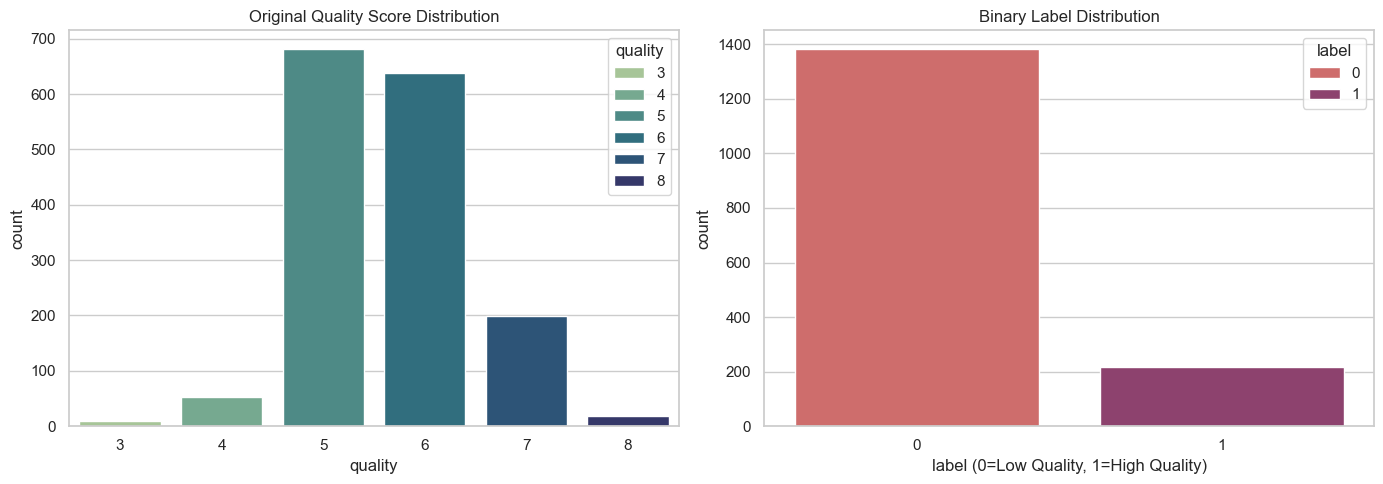

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(x='quality', data=df, ax=axes[0], palette='crest', hue='quality')
axes[0].set_title('Original Quality Score Distribution')
axes[0].set_xlabel('quality')
axes[0].set_ylabel('count')

sns.countplot(x='label', data=df, ax=axes[1], palette='flare', hue='label')
axes[1].set_title('Binary Label Distribution')
axes[1].set_xlabel('label (0=Low Quality, 1=High Quality)')
axes[1].set_ylabel('count')
plt.tight_layout()
plt.show()

## 4. 特征工程与可视化分析

绘制若干特征随标签变化的分布，以及相关系数热力图，用于辅助理解特征与目标变量的关系。

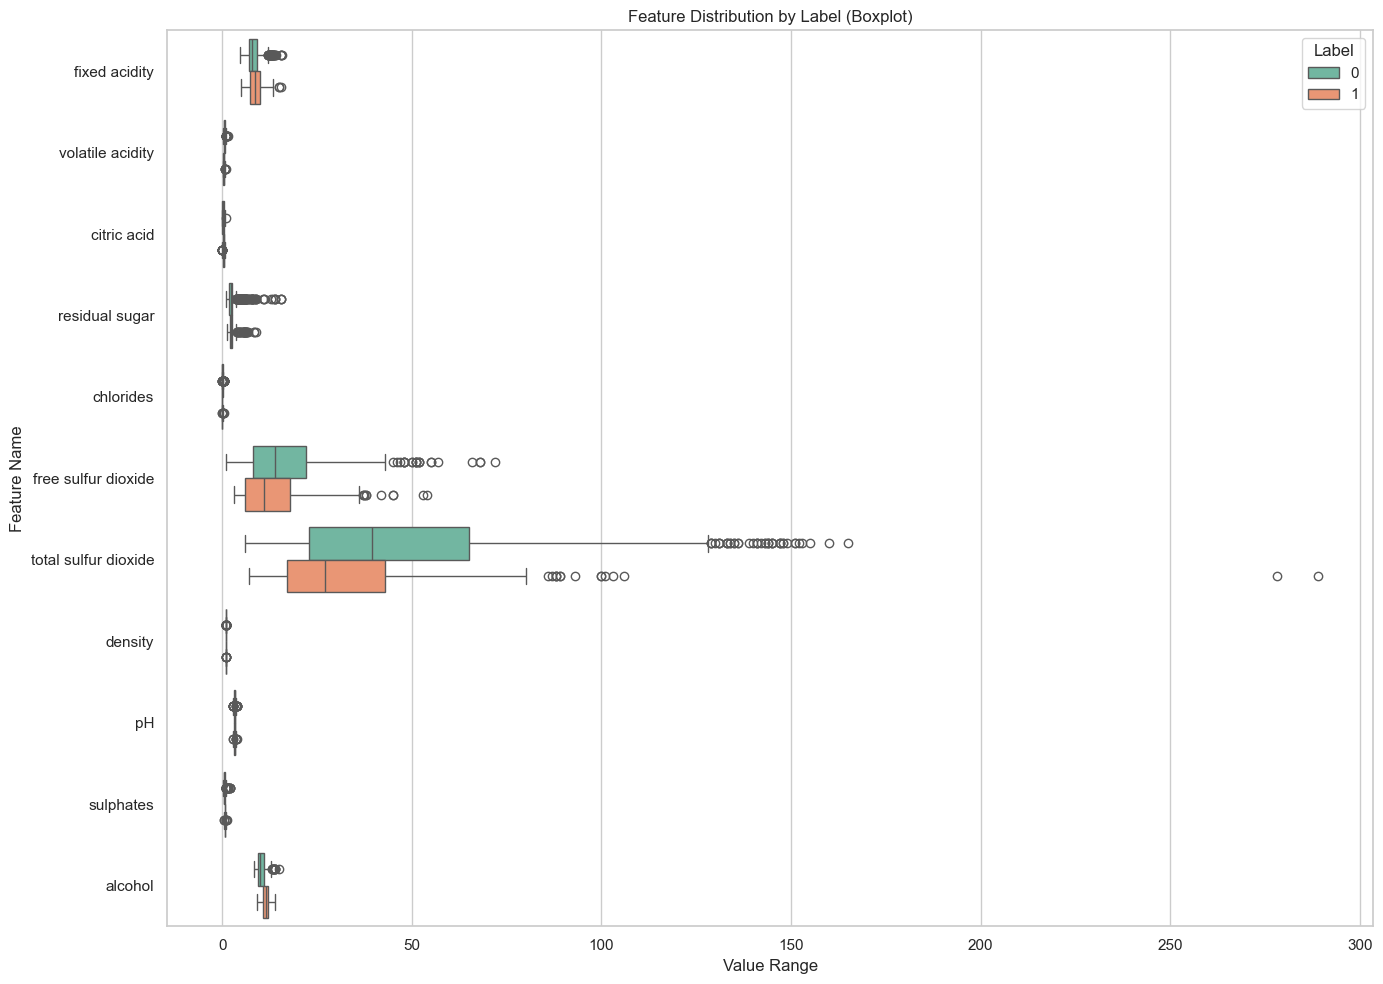

In [14]:
feature_cols = [col for col in df.columns if col not in {'quality', 'label'}]
melted = df.melt(id_vars='label', value_vars=feature_cols, var_name='feature', value_name='value')
plt.figure(figsize=(14, 10))
sns.boxplot(data=melted, x='value', y='feature', hue='label', orient='h', palette='Set2')
plt.title('Feature Distribution by Label (Boxplot)')
plt.xlabel('Value Range')
plt.ylabel('Feature Name')
plt.legend(title='Label', loc='upper right')
plt.tight_layout()
plt.show()

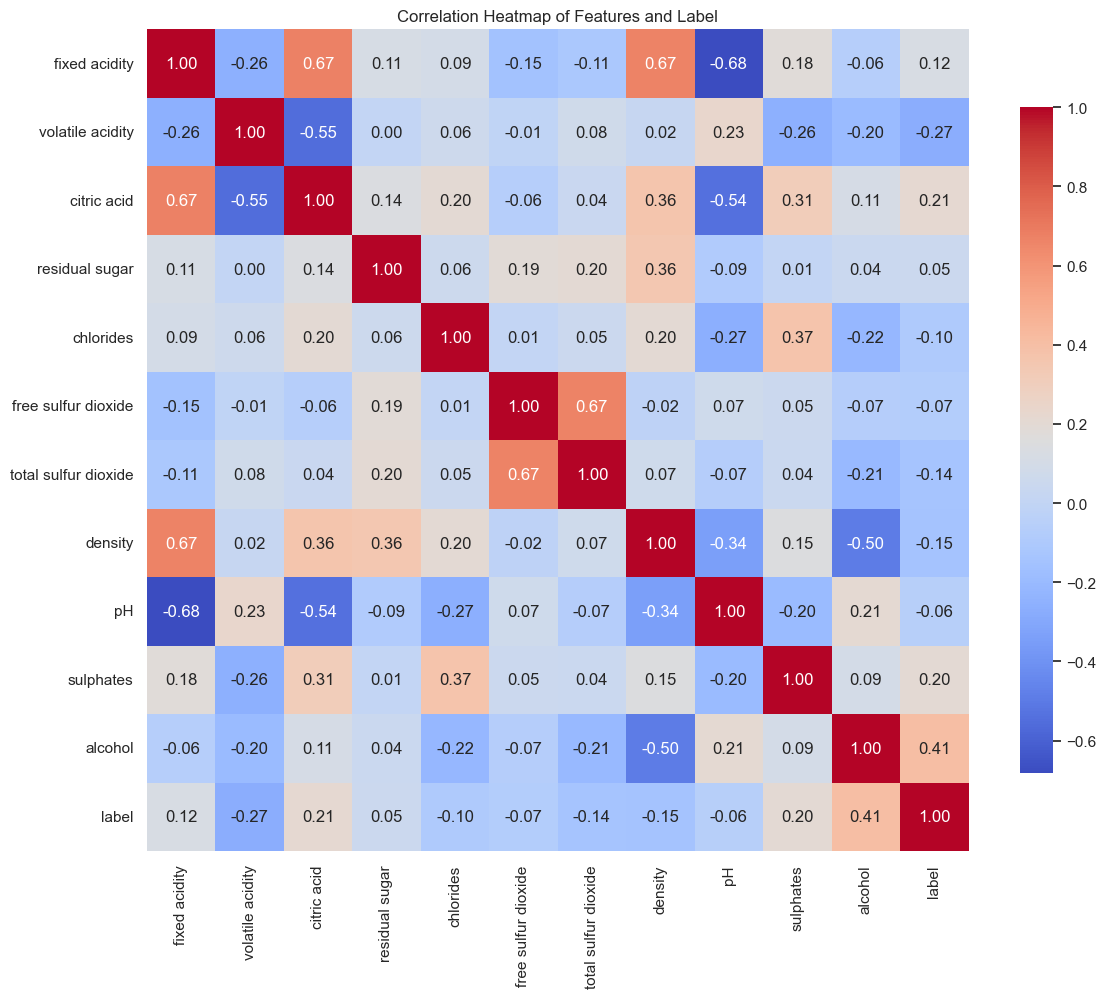

In [20]:
corr = df[feature_cols + ['label']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': 0.8})
plt.title('Correlation Heatmap of Features and Label')
plt.tight_layout()
plt.show()

## 5. 数据预处理

由于各特征的量纲与范围不同，先使用 `StandardScaler` 对特征进行标准化，为梯度下降与逻辑回归训练提供更稳定的数值条件。

In [22]:
X = df[feature_cols].to_numpy(dtype=float)
y = df['label'].to_numpy(dtype=int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:5]

array([[-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611],
       [-0.29854743,  1.96744245, -1.39147228,  0.04341614,  0.2238752 ,
         0.87263823,  0.62436323,  0.02826077, -0.7199333 ,  0.1289504 ,
        -0.58477711],
       [-0.29854743,  1.29706527, -1.18607043, -0.16942723,  0.09635286,
        -0.08366945,  0.22904665,  0.13426351, -0.33117661, -0.04808883,
        -0.58477711],
       [ 1.65485608, -1.38444349,  1.4841536 , -0.45321841, -0.26496041,
         0.10759209,  0.41150046,  0.6642772 , -0.97910442, -0.46118037,
        -0.58477711],
       [-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611]])

## 6. 手动实现逻辑回归（梯度下降）

实现一个支持 L2 正则化的逻辑回归类，使用批量梯度下降更新参数。
训练过程中记录损失变化，便于观察收敛情况。

In [23]:
class LogisticRegressionGD:
    def __init__(self, lr=0.1, max_iter=2000, tol=1e-6, l2=0.0, verbose=False):
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
        self.l2 = l2
        self.verbose = verbose
        self.theta_ = None
        self.loss_history_ = []

    @staticmethod
    def _sigmoid(z):
        return 1.0 / (1.0 + np.exp(-z))

    def _loss(self, X, y):
        logits = X @ self.theta_
        probs = self._sigmoid(logits)
        eps = 1e-12
        ce = -np.mean(y * np.log(probs + eps) + (1 - y) * np.log(1 - probs + eps))
        reg = 0.5 * self.l2 * np.sum(self.theta_[1:] ** 2)
        return ce + reg

    def fit(self, X, y):
        n_samples, n_features = X.shape
        X_bias = np.hstack([np.ones((n_samples, 1)), X])
        self.theta_ = np.zeros(n_features + 1)
        self.loss_history_.clear()

        for i in range(self.max_iter):
            logits = X_bias @ self.theta_
            probs = self._sigmoid(logits)
            errors = probs - y

            grad = X_bias.T @ errors / n_samples
            grad[1:] += self.l2 * self.theta_[1:]

            self.theta_ -= self.lr * grad
            loss = self._loss(X_bias, y)
            self.loss_history_.append(loss)

            if self.verbose and (i % 100 == 0 or i == self.max_iter - 1):
                print(f'Iter {i:4d}, loss={loss:.6f}')

            if i > 0 and abs(self.loss_history_[-2] - loss) < self.tol:
                if self.verbose:
                    print(f'Converged at iteration {i}.')
                break
        return self

    def predict_proba(self, X):
        if self.theta_ is None:
            raise ValueError('Model has not been fitted yet.')
        X_bias = np.hstack([np.ones((X.shape[0], 1)), X])
        return self._sigmoid(X_bias @ self.theta_)

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)

In [24]:
def evaluate_model(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return {
        'accuracy': accuracy_score(y_valid, preds),
        'precision': precision_score(y_valid, preds, zero_division=0),
        'recall': recall_score(y_valid, preds, zero_division=0),
        'f1': f1_score(y_valid, preds, zero_division=0)
    }

In [25]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
manual_scores = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_scaled), start=1):
    X_train, X_valid = X_scaled[train_idx], X_scaled[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]

    model = LogisticRegressionGD(lr=0.1, max_iter=5000, tol=1e-6, l2=0.01)
    fold_scores = evaluate_model(model, X_train, y_train, X_valid, y_valid)
    fold_scores['fold'] = fold
    manual_scores.append(fold_scores)

manual_df = pd.DataFrame(manual_scores).set_index('fold')
manual_df.assign(mean=manual_df.mean(axis=1))
manual_df


,accuracy,precision,recall,f1
fold,,,,
1,0.859375,0.555556,0.212766,0.307692
2,0.884375,0.666667,0.238095,0.350877
3,0.887500,0.681818,0.340909,0.454545
4,0.868750,0.588235,0.222222,0.322581
5,0.890282,0.583333,0.358974,0.444444


In [26]:
manual_summary = manual_df.mean().to_frame(name='手写逻辑回归 (5-fold mean)')
manual_summary.T

,accuracy,precision,recall,f1
手写逻辑回归 (5-fold mean),0.878056,0.615122,0.274593,0.376028


## 7. scikit-learn 逻辑回归基准

使用 scikit-learn 中的 `LogisticRegression` 进行 5 折交叉验证，并与手动实现的结果进行对比。

In [27]:
sklearn_scores = []
for fold, (train_idx, valid_idx) in enumerate(kf.split(X_scaled), start=1):
    X_train, X_valid = X_scaled[train_idx], X_scaled[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]

    clf = LogisticRegression(max_iter=5000, C=1.0, solver='lbfgs')
    clf.fit(X_train, y_train)
    preds = clf.predict(X_valid)

    sklearn_scores.append({
        'fold': fold,
        'accuracy': accuracy_score(y_valid, preds),
        'precision': precision_score(y_valid, preds, zero_division=0),
        'recall': recall_score(y_valid, preds, zero_division=0),
        'f1': f1_score(y_valid, preds, zero_division=0)
    })

sklearn_df = pd.DataFrame(sklearn_scores).set_index('fold')
sklearn_df


,accuracy,precision,recall,f1
fold,,,,
1,0.865625,0.590909,0.276596,0.376812
2,0.875000,0.545455,0.285714,0.375000
3,0.887500,0.666667,0.363636,0.470588
4,0.862500,0.521739,0.266667,0.352941
5,0.893417,0.586207,0.435897,0.500000


In [28]:
comparison = pd.concat({
    '手写逻辑回归': manual_df.mean(),
    'sklearn 逻辑回归': sklearn_df.mean()
}, axis=1).T
comparison

,accuracy,precision,recall,f1
手写逻辑回归,0.878056,0.615122,0.274593,0.376028
sklearn 逻辑回归,0.876808,0.582195,0.325702,0.415068


## 8. 心得与思考

- 通过特征探索可以发现酸度、硫含量等对酒的质量存在一定影响，
  但不同指标之间存在较强相关性，所以需要多注意多重共线性对模型的影响；
- 手写的逻辑回归在标准化和适当的学习率、正则化配置下能够收敛到与库函数相近的性能；
- scikit-learn 的实现对超参数更不敏感，且训练速度较快，适用于快速实验；
- 以后可以继续尝试调节阈值、采用分层交叉验证、引入特征选择等进一步优化模型表现。